# Classification: Who survived the Titanic?


In [95]:




# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams

%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [96]:


import cleantitanic2 
output_path = "/Users/efiathieniti/Documents/Dropbox/UVA/Data Mining/Assignments/"


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

print(len(train_set))

print(len(test_set))
# Combine the data to perform visualize and perform extractions
df = pd.concat([train_set, test_set])
df.head()

print(len(df))


['.DS_Store', 'gender_submission.csv', 'test.csv', 'train.csv']
891
418
1309


l



# Feature Engineering and Extraction

The following part  includes suggested feature engineering from from: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

and 


In [97]:
df_full = pd.concat([train_set, test_set])

print(sum(df_full['Age'].isnull()))

df_full.describe()


263


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


## Data Cleaning

In [98]:
from cleantitanic2 import substrings_in_string

import imp

import pandas as pd
import numpy as np
from scipy.stats import mode
import string
from matplotlib import pyplot as plt


title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))


df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
 
    

# Create 'title' Feature
df.groupby('Title')['PassengerId'].nunique().sort_values(ascending=False)



Title
Mr          758
Miss        258
Mrs         201
Master       61
Rev           8
Dr            8
Col           4
Ms            2
Major         2
Don           2
Mme           1
Mlle          1
Jonkheer      1
Countess      1
Capt          1
Name: PassengerId, dtype: int64

Some titles only appear once so we would not like the classifier to learn 'rules' for them as this would lead to overfittting. We will replaced them with the most frequenct ones:


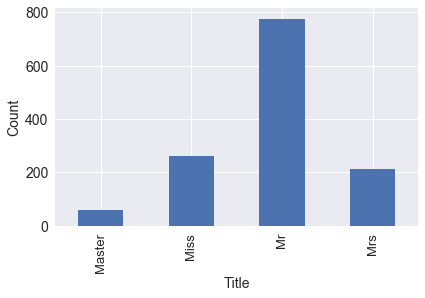

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:


#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

# DECK
#Turning cabin number into Deck
df['Title']=df.apply(replace_titles, axis=1)

#Special case for cabins as nan may be signal
df.Cabin = df.Cabin.fillna('Unknown') 
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
df['Deck']=df['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))



df.groupby('Title')['PassengerId'].count().plot(kind='bar')
plt.ylabel("Count")
plt.show()

# FAMILY SIZE

#Creating new family_size column
df['Family_Size']=df['SibSp']+df['Parch']


#Age*Class
# This is an interaction term, since age and class are both numbers we can just multiply them.

# Consider doing age*class after you categorize age?
# missing value for age
df['Age'][df['Age'].isnull()] = df['Age'].median()
df['Age*Class']=df['Age']*df['Pclass']


#Fare per Person
df['Fare_Per_Person']=df['Fare']/(df['Family_Size']+1)
df['Fare_Per_Person'][df['Fare_Per_Person'].isnull()] = df['Fare_Per_Person'].median()


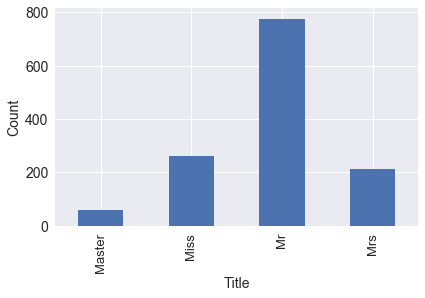

In [100]:
df.groupby('Title')['PassengerId'].count().plot(kind='bar')
plt.ylabel("Count")
plt.show()

#### Missing data

Cabin:
Cabin has a lot of missing values. If you have a cabin you are upper class so this could be an indicator. let's replace it with another column

In [101]:
df["hasCabin"] = pd.isnull(df['Cabin'])

####  Pairwise feature correlations  

# Find out most important features
## Features against class 
Here we try to find correlation between features and survival using plots
Metrics like mutual information can also be used
Order by Information gain / mutual information



/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


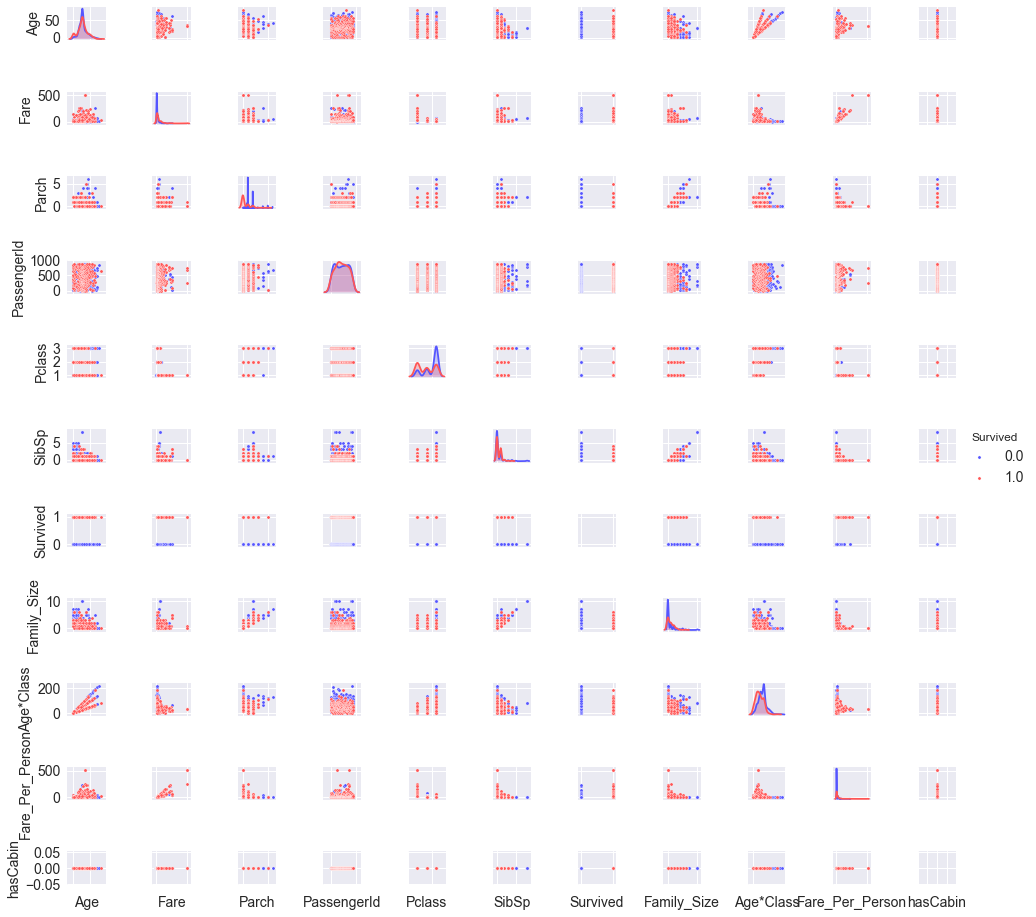

In [102]:
g = sns.pairplot(df, hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

#### 1. Discrete (Categorical or binary features)

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


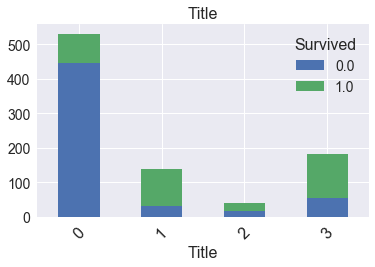

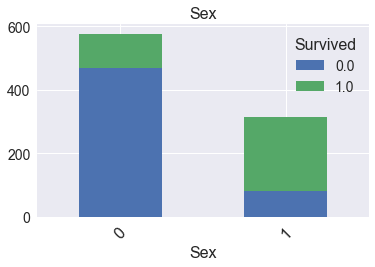

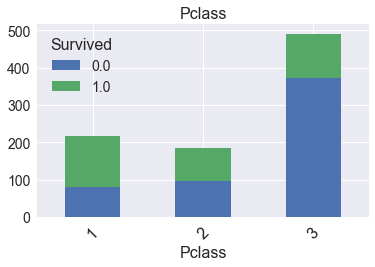

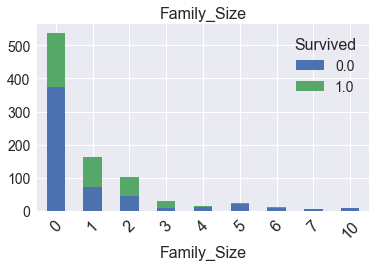

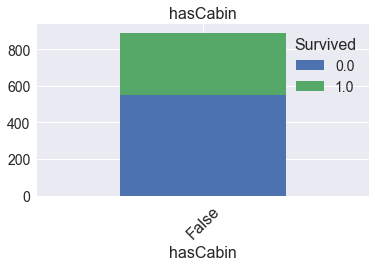

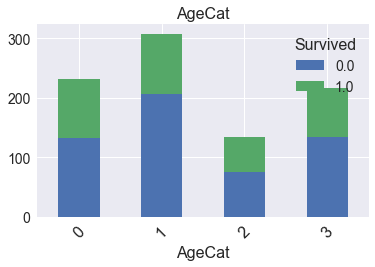

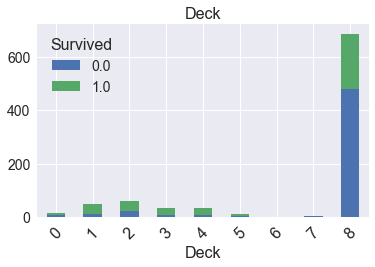

In [134]:

# Showing Information Gain
# For categorical values plot stacked barcharts

import scipy.stats 
df['AgeCat'] = pd.qcut(df['Age'],4,labels=[0,1,2,3])
df['AgeCat*Class']=df['AgeCat']*df['Pclass']

discrete_features = ['Title','Sex', 'Pclass', 'Family_Size', 'hasCabin', "AgeCat", "Deck"]

params = {'axes.labelsize': 16,'axes.titlesize':16, 'text.fontsize': 16, 'legend.fontsize': 14,
          'xtick.labelsize': 16, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 5.5, 4

matplotlib.rcParams.update(params)

def stacked_charts(df2, feature):
    df2 = df.groupby([feature,'Survived'])[feature].count().unstack('Survived')
    df2[[0,1]].plot(kind='bar', stacked=True)
    plt.title(feature)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_path + "information_gain_%s.png"%feature, format='png')
    
    plt.show()
    

for feature in discrete_features:
    stacked_charts(df, feature)
 


In [104]:
# Make categories numerical for the algorithms
df['Deck'] = df['Deck'].map( {'A': 0, 'B': 1, 'C': 2, 'D':3, 'E': 4, 'F': 5, 'T': 6, 'G':7, 'Unknown':8} ).astype(int)


#### 2. Continuous Features

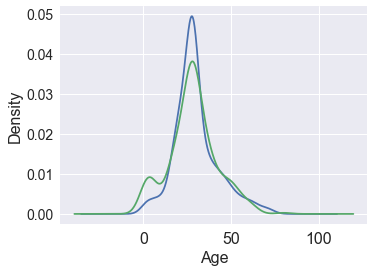

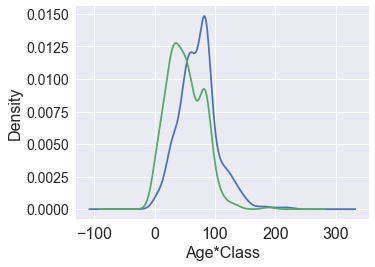

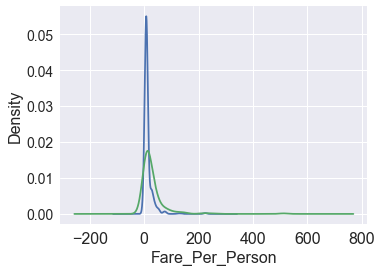

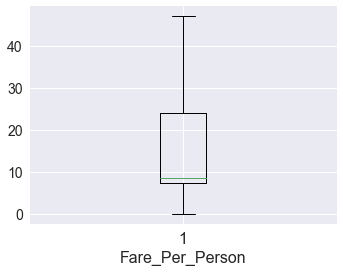

In [143]:
# For continuous plot boxplots or histograms

from pylab import *

feature = "Age"
df.groupby("Survived")[feature].plot(kind='kde')
plt.xlabel(feature)
plt.show()

plt.savefig(output_path + "information_gain_%s"%feature, format='png')

feature = "Age*Class"
df.groupby("Survived")[feature].plot(kind='kde')
plt.xlabel(feature)
plt.tight_layout()
plt.savefig(output_path + "information_gain_%s.png"%feature, format='png')
plt.show()



feature = "Fare_Per_Person"
df.groupby("Survived")[feature].plot(kind='kde')
plt.xlabel(feature)
plt.show()
plt.savefig(output_path + "information_gain_%s.png"%feature, format='png')




plt.boxplot(df[feature], showfliers=False)
plt.show
plt.xlabel(feature)
plt.savefig(output_path + "information_gain_%s.png"%feature, format='png')
plt.show()


Embarked: Some values are missing in embarked, so we can fill them in with the most popular category: S

In [106]:

df['Sex'][df['Sex'].isnull()] = 'male'
df['Sex'] = df['Sex'].map({'male':0, 'female':1})

df['Sex*Class']=df['Sex']*df['Pclass']


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [107]:

df['Embarked'][df['Embarked'].isnull()] = 'S'
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

df['Title'] = df['Title'].map( {'Mr': 0, 'Mrs': 1, 'Master': 2, 'Miss':3} ).astype(int)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Conclusions:
A larger percentage of females compared to males seem to have survived, and a larger percentage of 1st class compared to 3rd class have survived.
A larger proportion of 'master' rather than 'mr' has survived so this could be another indicator.

Maybe make a linear combination of sex and class?


In [108]:
# NAIVE BAYES
# ATTRIBUTES ARE INDEPENDENT
# DO NOT USE SEX + TITLE
# Measure informativenes??


# Build Classifier and Evaluation

In [109]:
import csv


In [110]:
def model_predict(model, X_train, y_train, mode):
    # Makes predictions for the test dataset and writes to file 
    # for kaggle submission
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = [int(x) for x in predictions]
    if mode == 'partial':
        csv_file = open(output_path+'/predictions_%s.csv'%models_names[model_to_plot] , 'w')
        passengerId = np.array(range(train_set.shape[0]+1,full_set.shape[0]+1))
        preds = dict(zip(passengerId, predictions))
        writer = csv.writer(csv_file)
        writer.writerow(["PassengerId","Survived"])
        for key, value in preds.items():
            writer.writerow([key, value])

               
    
def plot_running_auc(model_auc, metric, model_name, feats, mode, cv ):
    plt.plot(model_auc)
    plt.ylabel(metric)
    plt.title(model_name)
    plt.xticks(np.arange(len(feats)),feats,  rotation=45)
    plt.savefig(output_path + "auc_by_feature_%s_%s_cv%s.png"%(models_names[model_to_plot], mode, cv), format='png')
    plt.tight_layout()  
    plt.show()
    

In [ ]:


sum(df[])


Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title', 'Deck',
       'Family_Size', 'Age*Class', 'Fare_Per_Person', 'hasCabin', 'AgeCat',
       'Sex*Class', 'AgeCat*Class'],
      dtype='object')
         f1  accuracy    recall   roc_auc
0  0.479207  0.679453  0.398693  0.681879
1  0.707251  0.786496  0.680882  0.834088
2  0.717886  0.795536  0.683987  0.839815
3  0.718536  0.798870  0.678105  0.847516
4  0.710430  0.791066  0.675163  0.850203
5  0.720958  0.799094  0.681373  0.853311
LogisticRegression


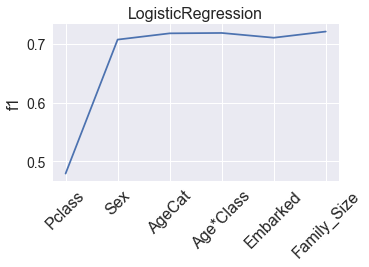

LogisticRegression
[[479  70]
 [109 233]]
         f1  accuracy    recall   roc_auc
0  0.720465  0.793834  0.731536  0.826665
1  0.740246  0.802676  0.708170  0.830011
2  0.745507  0.808383  0.713725  0.837321
3  0.741368  0.804923  0.722876  0.841725
4  0.740243  0.807148  0.725654  0.833126
5  0.730305  0.806184  0.719935  0.832803
6  0.741144  0.807272  0.725654  0.837295
RandomForestClassifier


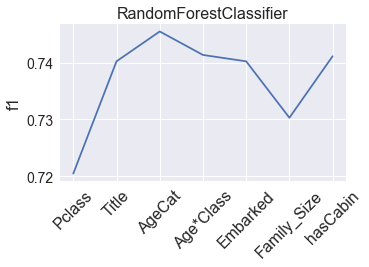

RandomForestClassifier
[[468  81]
 [ 97 245]]
         f1  accuracy    recall   roc_auc
0  0.733984  0.817224  0.673203  0.840708
1  0.752288  0.828487  0.693791  0.843604
2  0.744041  0.822931  0.684967  0.847374
3  0.753459  0.828513  0.696569  0.853974
4  0.636250  0.756563  0.561928  0.812446
5  0.631018  0.754316  0.556046  0.812698
6  0.630490  0.752069  0.558987  0.812531
SVC


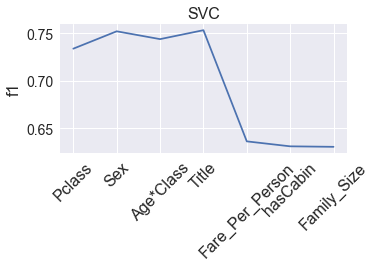

SVC
[[479  70]
 [151 191]]
         f1  accuracy    recall   roc_auc
0  0.717758  0.769113  0.772386  0.844573
1  0.735576  0.780278  0.798366  0.850027
2  0.720936  0.775857  0.757190  0.847343
3  0.727439  0.780327  0.768954  0.848016
GaussianNB


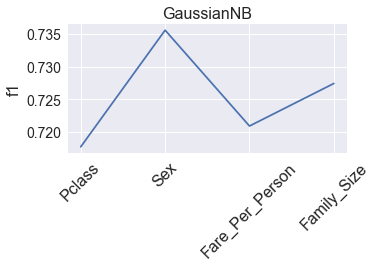

GaussianNB
[[432 117]
 [ 79 263]]


,f1,accuracy,recall,roc_auc
names,,,,
LogisticRegression,0.720958,0.799094,0.681373,0.853311
RandomForestClassifier,0.741144,0.807272,0.725654,0.837295
SVC,0.630490,0.752069,0.558987,0.812531
GaussianNB,0.727439,0.780327,0.768954,0.848016


In [141]:
## Finalise the dataset
print(df.columns)

from sklearn.metrics import confusion_matrix

# Choose setting 
mode = 'Full' # 'Full' or 'partial'
#model_to_plot=0 # 0 or 1
mode = 'partial'
if mode =='Full':
    all_features =["Pclass", "Sex", "Age*Class", "Title","AgeCat","hasCabin", "Fare_Per_Person", "Family_Size", "SibSp", "Parch",
                   "Embarked", "Age"]
    all_possible_features = [all_features,all_features]
elif mode == 'partial':
    all_possible_features=[[]]*5
    # Regression
    # Remove Family Size
    all_possible_features[0] =["Pclass", "Sex","AgeCat","Age*Class", "Embarked","Family_Size" ]
    # Select ageCat for the regression
    # select age*class for rf

    all_possible_features[1] =["Pclass", "Title","AgeCat","Age*Class","Embarked", "Family_Size", "hasCabin" ]

    all_possible_features[2] =["Pclass", "Sex", "Age*Class","Title","Fare_Per_Person","hasCabin","Family_Size" ]

    all_possible_features[3] =["Pclass", "Sex","Fare_Per_Person","Family_Size" ]

else:
    print('Error: Mode not in "Full" or "partial"')



select = ['Survived']
auc = []

models_names = [ 'LogisticRegression', 'RandomForestClassifier', 'SVC' , 'GaussianNB']
metric = 'f1'
cv=20
models = [ LogisticRegression,  RandomForestClassifier , SVC, GaussianNB]

model_scores = []

plot_auc = True
for model_to_plot in range(len(models)):
    elem = models[model_to_plot]
    model = elem()
    model_auc = []
    model_feature_scores = []
    for feature  in all_possible_features[model_to_plot]:
        select.append(feature)
        final_df = df[select]

        # First split the data into train and test
        full_set=final_df

        # Extract the train and test from the new data_frame
        cols = list(set(full_set.columns) - set(['Survived']))
        X_train, X_test = full_set[:train_set.shape[0]][cols], full_set[train_set.shape[0]:][cols]
        y_train = full_set[:train_set.shape[0]]['Survived']
    
        # Running some models, testing with small cross_validation and f1 metric (binary target) and running the prediction
        # with all the training set
    
        mscores = [] # feature scores 
        lscores = ['f1','accuracy','recall','roc_auc']
        np.random.seed(42) # for reproducibility of results 
        for sc in lscores:
            scores = cross_val_score(model, X_train, y_train, scoring=sc, cv=cv)
            mscores.append(np.mean(scores))
        
        model_feature_scores.append(mscores)
            
 
    # Once it goes through all features gather and plot
    model_scores.append(model_feature_scores[-1])

    model_feature_scores = pd.DataFrame(model_feature_scores, columns=lscores)
    print(model_feature_scores)
    model_auc = model_feature_scores[metric]
    model_name = models_names[model_to_plot]
    print(model_name)

    if plot_auc:
        feats = all_possible_features[model_to_plot]
        plot_running_auc(model_auc, metric, model_name, feats, mode, cv)
    # Finally only save the last feature
  
    # Only predict and save stats for the final model that includes all features
    model_predict(model, X_train, y_train, mode) 
    y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    conf_mat = confusion_matrix(y_train,y_pred)
    print(model_name)
    print(conf_mat)
            
        
        
model_scores = pd.DataFrame(model_scores, columns=lscores)
model_scores['names']=models_names
model_scores = model_scores.set_index('names')
model_scores   


In [129]:
#Check class balance
print("1",sum(y_train))
print("total",len(y_train))
print("1",sum(y_train)/len(y_train))


316/576


1 342.0
total 891
1 0.3838383838383838


0.5486111111111112

In [ ]:
model_scores

In [ ]:
## Finalise the dataset
print(df.columns)

# Choose setting 
mode = 'Full' # 'Full' or 'partial'
model_to_plot=0 # 0 or 1
mode = 'partial'
if mode =='Full':
    all_features =["Pclass", "Sex", "Age*Class", "Title","AgeCat","hasCabin", "Fare_Per_Person", "Family_Size", "SibSp", "Parch",
                   "Embarked", "Age"]
    all_possible_features = [all_features,all_features]
elif mode == 'partial':
    all_possible_features=[[]]*5
    # Regression
    # Remove Family Size
    all_possible_features[0] =["Pclass", "Sex", "AgeCat","Age*Class", "Embarked","Family_Size" ,
                        "Title"]
    # Select ageCat for the regression
    # select age*class for rf
    all_possible_features[1] =["Pclass", "Sex", "Age*Class","Title","Fare_Per_Person","hasCabin","Family_Size" ]
    all_possible_features[2] =["Pclass", "Sex", "Age*Class","Title","Fare_Per_Person","hasCabin","Family_Size" ]

    all_possible_features[3] =["Pclass", "Sex","Fare_Per_Person","Family_Size" ]

else:
    print('Error: Mode not in "Full" or "partial"')





# For SVM use Age continuous as it can learn nonlinear relationships
#selected_features =["Pclass", "Sex", "Age*Class", "Fare_Per_Person", "hasCabin", 
#                    "Title","Survived",
#                   "Family_Size", "Embarked", "Age"]

select = ['Survived']
auc = []

models_names = [ 'LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier' , 'GaussianNB']
metric = 'roc_auc'
cv=4
models = [ LogisticRegression,  RandomForestClassifier , SVC, GaussianNB]

for feature  in all_possible_features[model_to_plot]:
    select.append(feature)
    print(select)
    final_df = df[select]

    # First split the data into train and test
    full_set=final_df

    # Extract the train and test from the new data_frame
    cols = list(set(full_set.columns) - set(['Survived']))
    X_train, X_test = full_set[:train_set.shape[0]][cols], full_set[train_set.shape[0]:][cols]
    y_train = full_set[:train_set.shape[0]]['Survived']
    
        # Running some models, testing with small cross_validation and f1 metric (binary target) and running the prediction
    # with all the training set
    
    mscores = []
    lscores = ['f1','accuracy','recall','roc_auc']
    np.random.seed(42) # Reproducibility of results is very important!
    for elem in models:
        mscores2 = []
        model = elem()
        for sc in lscores:
            scores = cross_val_score(model, X_train, y_train, scoring=sc, cv=cv)
            y_pred = cross_val_predict(model, X_train, y_train, scoring=sc, cv=cv)
            conf_mat = confusion_matrix(y_train,y_pred)
            
            mscores2.append(np.mean(scores))
            mscores.append(mscores2)
        model_predict(model, X_train, y_train, mode)       
    scores = pd.DataFrame(mscores, columns=lscores)
    print(scores.ix[model_to_plot,metric])
    auc.append(scores.ix[model_to_plot,metric])

plt.plot(auc)
plt.ylabel(metric)
plt.title(models_names[model_to_plot])
plt.xticks(np.arange(len(all_possible_features[model_to_plot])), all_possible_features[model_to_plot],  rotation=45)
plt.savefig(output_path + "auc_by_feature_%s_%s_cv%s.png"%(models_names[model_to_plot], mode, cv), format='png')
plt.tight_layout()  
plt.show()
    

In [ ]:
sum(X_test.isnull())

In [ ]:
print(len(X_test))
print(len(X_train))

In [ ]:
ynew = model.predict(Xnew)

In [ ]:




plt.plot(auc)
plt.ylabel(metric)
plt.title(models_names[model_to_plot])
plt.xticks(np.arange(len(all_possible_features[model_to_plot])), all_possible_features[model_to_plot],  rotation=45)
plt.savefig(output_path + "auc_by_feature_%s_%s.png"%(models_names[model_to_plot], mode), format='png')
plt.show()

In [ ]:

rcParams['figure.figsize'] = 6, 4

plt.plot(auc)
plt.ylabel(metric)
xticks(np.arange(len(all_possible_features[model_to_plot])), all_possible_features[model_to_plot],  rotation=35)
plt.title(models_names[model_to_plot])
plt.savefig(output_path + "auc_by_feature_%s_%s.png"%(models_names[model_to_plot], mode), format='png')
plt.show()

In [ ]:
# Consider 

## Build Classifier



In [ ]:
## Linear Regression  and random forest - better if features are linear
## SVM: okay with non-linear



In [ ]:
X_test

In [ ]:
# Running some models, testing with small cross_validation and f1 metric (binary target) and running the prediction
# with all the training set
models = [ LogisticRegression, SVC, LinearSVC, RandomForestClassifier, KNeighborsClassifier ]
mscores = []
lscores = ['f1','accuracy','recall','roc_auc']
np.random.seed(42) # Reproducibility of results is very important!
for elem in models:
    mscores2 = []
    model = elem()
    
    for sc in lscores:
        scores = cross_val_score(model, X_train, y_train, scoring=sc)
        mscores2.append(np.mean(scores))
    mscores.append(mscores2)
scores = pd.DataFrame(mscores, columns=lscores)
scores

Logistic Regression performs better with age categorical

In [ ]:
mscores